### Persistent homology examples

* Ripser [paper](https://www.theoj.org/joss-papers/joss.00925/10.21105.joss.00925.pdf) [code](https://github.com/scikit-tda/ripser.py) (fast)
* Dionysus 2 [code](https://mrzv.org/software/dionysus2/) (representative examples)
* Nico's [code](https://github.com/nhchristianson/Math-text-semantic-networks)
* Ann's [code](https://github.com/asizemore/PH_tutorial/blob/master/Tutorial_day1.ipynb)

In [ ]:
import dionysus as d
s = d.Simplex([0,1,2])
print("Dimension:", s.dimension())
simplices = [([2], 4), ([1,2], 5), ([0,2], 6),
             ([0], 1),   ([1], 2), ([0,1], 3),
             ([0,1,2], 7), ([3], 8), ([0,3], 9),
             ([2,3], 10), ([1,3], 11), ([1,2,3], 11),
             ([0,2,3], 12), ([0,1,3], 13),
             ([0,1,2,3], 14)]
f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))
f.sort()
for s in f:
    print(s)
m = d.homology_persistence(f, method = 'column')
dgms = d.init_diagrams(m, f)
print(dgms)
for i, dgm in enumerate(dgms):
    for pt in dgm:
        print(i, pt.birth, pt.death)

In [ ]:
from ripser import ripser
import persim
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
data = datasets.make_circles(n_samples=100)[0] + 5 * datasets.make_circles(n_samples=100)[0]
print(data[:10])
plt.subplot(1,2,1)
ax = sns.scatterplot(x=data[:,0], y=data[:,1], hue=range(0,100))
ax.set_aspect('equal', 'box')
dgms = ripser(data, maxdim=2)['dgms']
plt.subplot(1,2,2)
persim.plot_diagrams(dgms, show=True)
print(len(dgms))
# print(dgms[:10])
print(dgms[1][:10])

In [ ]:
import numpy as np
data = np.random.rand(50,50)
dgms = ripser(data, distance_matrix=True, maxdim=4)['dgms']
persim.plot_diagrams(dgms, show=True)

#### Load graphs

In [1]:
topics = ['biochemistry']
# path_saved = '/Users/harangju/Box Sync/Research/my papers/wikipedia paper/data/graphs/full_page/dated/filled/'
path_saved = '/Users/harangju/Box Sync/Research/my papers/wikipedia paper/data/graphs/top_section/dated/filled/'

In [2]:
import networkx as nx

graphs = {}
for topic in topics:
    graphs[topic] = nx.read_gexf(path_saved + topic + '.gexf')
graphs

{'biochemistry': <networkx.classes.digraph.DiGraph at 0x7f8c78909908>}

In [3]:
graph = graphs[topics[0]]

#### Fill empty years with infinity

In [4]:
import math

for name in graph.nodes:
    if 'year' not in graph.nodes[name].keys():
        graph.nodes[name]['year'] = 2019#math.inf

#### Convert network into numbered nodes

In [5]:
import networkx as nx

def number_graph(graph):
    """ replaces nodes with an integer index
    Returns
    -------
    numbered_graph: networkx.DiGraph
    nodes: list
        index in list is index in graph
    years: list
        index of years
    """
    nodes = [n for n in graph.nodes()]
    years = [graph.nodes[n]['year'] for n in graph.nodes()]
    years = sorted(list(set(years)))
    numbered = nx.DiGraph()
    for node in graph.nodes:
        numbered.add_node(nodes.index(node),
                          year = 1 + years.index(graph.nodes[node]['year']))
        numbered.add_edges_from([(nodes.index(node), nodes.index(succ))
                                 for succ in graph.successors(node)])
    return numbered, nodes, years

In [6]:
numbered, nodes, years = number_graph(graph)
print('Years:', years[:10])
print('Nodes:', nodes[:4])
node = 'Atom'
print('"{}": {}'.format(node, graph.nodes[node]))
print('"{}": nodes[{}] = {}'.format(node,
                                    nodes.index(node),
                                    numbered.nodes[nodes.index(node)]))

Years: [-2500, -2000, -700, -500, -430, -400, -360, -300, 100, 111]
Nodes: ['Chemical element', 'Chemistry', 'Chemical compound', 'Atom']
"Atom": {'year': 1800, 'label': 'Atom'}
"Atom": nodes[3] = {'year': 49}


### Try persistent homology

#### Ripser
Don't know how to use :(

In [ ]:
import numpy as np
# data = np.random.rand(50,50)
data = nx.convert_matrix.to_numpy_array(nx.Graph(graph))
dgms = ripser(data, distance_matrix=True, maxdim=3)['dgms']
persim.plot_diagrams(dgms, show=True)

#### Dionysus
Slower, but easy to understand.

In [7]:
# Calculate cliques
cliques = list(nx.algorithms.clique.enumerate_all_cliques(nx.Graph(graph)))
print(cliques[:5])
print([[nodes.index(n) for n in ns] for ns in cliques[:5]])
cliques = list(nx.algorithms.clique.enumerate_all_cliques(nx.Graph(numbered)))
cliques.sort(key = lambda x: (len(x), x[0]))
print(cliques[:5])

[['Chemical element'], ['Chemistry'], ['Chemical compound'], ['Atom'], ['Molecule']]
[[0], [1], [2], [3], [4]]
[[0], [1], [2], [3], [4]]


In [8]:
# Compute {year: [nodes with that year]}
node_for_year = {year: [nodes.index(n) for n in nodes if graph.nodes[n]['year']==year]
                 for year in years}
{k: node_for_year[k] for k in years[:5]}

{-2500: [60, 206],
 -2000: [168, 314, 433, 680],
 -700: [66],
 -500: [189, 278, 486],
 -430: [74, 231]}

In [9]:
# how to get cliques in growing graph
print(node_for_year[-2500])
[clique for clique in cliques 
 if all([n in node_for_year[-2500] for n in clique])]

[60, 206]


[[60], [206]]

#### Compute simplices
Example format:
``` python
simplices = [([2], 4), ([1,2], 5), ([0,2], 6),
             ([0], 1),   ([1], 2), ([0,1], 3)]
```
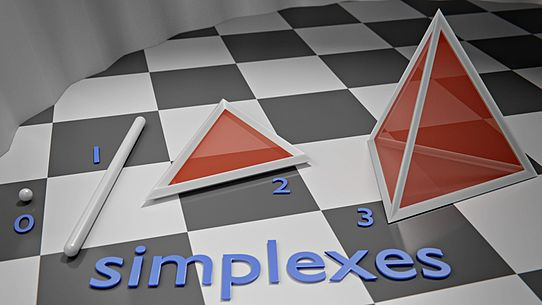

In [10]:
# Create filtration with cliques
import dionysus as d
f = d.Filtration()
nodes_so_far = []
for year, nodes_now in node_for_year.items():
    print(year, end=' ')
    nodes_so_far.extend(nodes_now)
    for clique in cliques:
        if all([n in nodes_so_far for n in clique]):
            f.append(d.Simplex(clique, year))
print('')
f.sort()
f

-2500 -2000 -700 -500 -430 -400 -360 -300 100 111 126 160 182 273 600 698 700 800 900 1000 1100 1250 1300 1400 1452 1500 1598 1599 1600 1614 1665 1668 1669 1671 1676 1680 1700 1727 1735 1747 1752 1768 1772 1776 1780 1782 1783 1791 1800 1802 1803 1804 1806 1815 1817 1820 1822 1823 1824 1827 1830 1835 1836 1838 1840 1841 1842 1845 1848 1849 1850 1856 1857 1858 1859 1860 1863 1864 1865 1869 1872 1876 1879 1880 1883 1886 1888 1889 1894 1895 1896 1897 1898 1900 1901 1902 1903 1905 1906 1907 1908 1909 1910 1911 1912 1913 1915 1916 1920 1921 1923 1925 1926 1927 1929 1930 1935 1936 1938 1939 1940 1941 1946 1947 1949 1950 1951 1952 1953 1954 1956 1959 1960 1964 1965 1969 1970 1973 1974 1976 1978 1982 1983 1985 1986 1998 2001 2012 2017 2019 


Filtration with 11251 simplices

In [157]:
year = -500
simplex = [1, 2]
nodes = [n for y in node_for_year if y <= year for n in node_for_year[y]]
[s for s in cliques if all([n in s for n in simplex])]

[[1, 2],
 [0, 1, 2],
 [1, 3, 2],
 [1, 2, 5],
 [1, 2, 4],
 [1, 2, 103],
 [1, 2, 99],
 [1, 2, 94],
 [1, 2, 8],
 [1, 2, 9],
 [0, 1, 3, 2],
 [0, 1, 2, 5],
 [0, 1, 2, 4],
 [0, 1, 2, 8],
 [1, 3, 2, 5],
 [1, 3, 2, 4],
 [1, 3, 2, 8],
 [1, 2, 5, 8],
 [1, 2, 4, 8],
 [1, 2, 4, 9],
 [1, 2, 99, 94],
 [1, 2, 8, 9],
 [0, 1, 3, 2, 5],
 [0, 1, 3, 2, 4],
 [0, 1, 3, 2, 8],
 [0, 1, 2, 5, 8],
 [0, 1, 2, 4, 8],
 [1, 3, 2, 5, 8],
 [1, 3, 2, 4, 8],
 [1, 2, 4, 8, 9],
 [0, 1, 3, 2, 5, 8],
 [0, 1, 3, 2, 4, 8]]

In [108]:
m = d.homology_persistence(f)

In [123]:
for i in range(len(m)):
    if m.pair(i) < i: continue      # skip negative simplices
    dim = f[i].dimension()
    birth = int(f[i].data)
    if m.pair(i) != m.unpaired:
        death = int(f[m.pair(i)].data)
        nodes_at_death = [nodes[n] for n in node_for_year[death]]
        killer_nodes = [n for n in nodes_at_death]
        print('dim={}, {},\n\t({}, {}) {}'.format(dim, [nodes[s] for s in f[i]], 
                                                  birth, death,
                                                  nodes_at_death))
    else:
        print('dim={}, {},\n\t({}, _)'.format(dim, [nodes[s] for s in f[i]], birth))

dim=0, ['Carbon'],
	(-2500, _)
dim=0, ['Nutrition'],
	(-2500, 800) ['Ethanol']
dim=0, ['Alcohol'],
	(-2000, -2000) ['Alcohol', 'Medicine', 'Pharmacist', 'Pesticide']
dim=0, ['Medicine'],
	(-2000, 1600) ['Pharmacology', 'Life', 'Evolution', 'Cell biology', 'Diffusion', 'Drug']
dim=0, ['Pharmacist'],
	(-2000, -2000) ['Alcohol', 'Medicine', 'Pharmacist', 'Pesticide']
dim=0, ['Pesticide'],
	(-2000, 1669) ['Phosphorus']
dim=0, ['Sugar'],
	(-700, 800) ['Ethanol']
dim=0, ['Sulfur'],
	(-500, -360) ['Chemical element']
dim=0, ['Microbiology'],
	(-500, 1599) ['Virology']
dim=0, ['Phylogenetics'],
	(-500, 1600) ['Pharmacology', 'Life', 'Evolution', 'Cell biology', 'Diffusion', 'Drug']
dim=0, ['Immune system'],
	(-430, 1600) ['Pharmacology', 'Life', 'Evolution', 'Cell biology', 'Diffusion', 'Drug']
dim=0, ['T cell'],
	(-430, -430) ['Immune system', 'T cell']
dim=0, ['Physiology'],
	(-400, -300) ['Chemistry', 'Solution', 'Mixture', 'Concentration', 'Emulsion', 'Colorimeter (chemistry)']
dim=0, ['Mi

	(1916, 1916) ['Chemical compound', 'Peptide bond', 'Monosaccharide', 'Ribose', 'Hydrocarbon', 'Chemical formula', 'Ester', 'Acid', 'Covalent bond', 'Citric acid', 'Functional group', 'Aliphatic compound', 'Alicyclic compound', 'Water', 'Glycoprotein', 'Covalent radius', 'Valence bond theory', 'Structural formula', 'Inorganic chemistry', 'Colloid', 'Colony-stimulating factor', 'Macrophage colony-stimulating factor', 'Enzyme inhibitor', 'Non-competitive inhibition', 'Cycloleucine', 'Uric acid', 'Feedback inhibition', 'Intermolecular force', 'Laminin', 'Membrane glycoprotein', 'Molar volume', 'Phenyl group', 'Selectin', 'Vitronectin', 'Steroid 17alpha-monooxygenase']
dim=1, ['Chemical formula', 'Organic chemistry'],
	(1916, 1916) ['Chemical compound', 'Peptide bond', 'Monosaccharide', 'Ribose', 'Hydrocarbon', 'Chemical formula', 'Ester', 'Acid', 'Covalent bond', 'Citric acid', 'Functional group', 'Aliphatic compound', 'Alicyclic compound', 'Water', 'Glycoprotein', 'Covalent radius', 'Val

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
m = d.homology_persistence(f)
dgms = d.init_diagrams(m, f)
print(dgms)
for i, dgm in enumerate(dgms):
    for j, pt in enumerate(dgm):
        print(i, pt.birth, pt.death, [nodes[s] for s in f[j]], end=' ')
        if pt.death != np.inf:
            print([nodes[n] for n in node_for_year[pt.death]])
        else:
            print('')

[Diagram with 47 points, Diagram with 788 points, Diagram with 104 points, Diagram with 1 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points, Diagram with 0 points]
0 -2500.0 inf ['Carbon'] 
0 -2500.0 800.0 ['Nutrition'] ['Ethanol']
0 -2000.0 1600.0 ['Alcohol'] ['Pharmacology', 'Life', 'Evolution', 'Cell biology', 'Diffusion', 'Drug']
0 -2000.0 1669.0 ['Medicine'] ['Phosphorus']
0 -700.0 800.0 ['Pharmacist'] ['Ethanol']
0 -500.0 -360.0 ['Pesticide'] ['Chemical element']
0 -500.0 1599.0 ['Carbon', 'Alcohol'] ['Virology']
0 -500.0 1600.0 ['Medicine', 'Pharmacist'] ['Pharmacology', 'Life', 'Evolution', 'Cell biology', 'Diffusion', 'Drug']
0 -430.0 1600.0 ['Sugar'] ['Pharmacology', 'Life', 'Evolution', 'Cell biology', 'Diffusion', 'Drug']
0 -400.0 -300.0 ['Sulfur'] ['Chemistry', 'Solution', 'Mixture', 'Concentration', 'Emulsion', 'Colorimeter (chemistry)']
0 100.0 1614.0 ['Microbiology'] ['Metabolism', 'Triiodothyronine']
0 160.0 1671.0 ['Phylogenetics'] ['Hydrogen

1 2017.0 inf ['Beta-1 adrenergic receptor'] 
1 2017.0 inf ['Genetics'] 
1 2017.0 inf ['Biosalinity'] 
1 2017.0 inf ['Ligand'] 
1 2017.0 inf ['Cadherin'] 
1 2017.0 inf ['Genetic carrier'] 
1 2017.0 inf ['Histone'] 
1 2017.0 inf ['Dendritic spine'] 
1 2017.0 inf ['Evolutionary developmental biology'] 
1 2017.0 inf ['Molecular orbital'] 
1 2017.0 inf ['Vasoactive intestinal peptide'] 
1 2017.0 inf ['Gel electrophoresis'] 
1 2017.0 inf ['Heterocyclic compound'] 
1 2017.0 inf ['Histamine receptor'] 
1 2017.0 inf ['Intramolecular force'] 
1 2017.0 inf ['Molecular mechanics'] 
1 2017.0 inf ['Kinetic energy'] 
1 2017.0 inf ['Somatostatin'] 
1 2017.0 inf ['Serpin'] 
1 2017.0 inf ['Phenol'] 
1 2017.0 inf ['Plasmin'] 
1 2017.0 inf ['Plasminogen'] 
1 2017.0 inf ['Polymyxin'] 
1 2017.0 inf ['Timeline of biology and organic chemistry'] 
1 2017.0 inf ['Transforming growth factor beta'] 
1 2017.0 inf ['Chemical element', 'Atom'] 
1 2017.0 inf ['Chemical element', 'Amino acid'] 
1 2017.0 inf ['Chemical

#### Plotting

In [98]:
import math

def betti_curves(diagrams):
    """
    Parameters
    ----------
    diagrams: dionysus.DiagramPoint
        persistence diagram with elements
        (int betti_number, int start, int death)
    Returns
    -------
    curves: numpy array
        {int betti_number: numpy.array}
    """
    betti_numbers = [i for i, _ in enumerate(dgms)]
    birth = [pt.birth for dgm in diagrams for pt in dgm]
    death = [pt.death for dgm in diagrams for pt in dgm]
    times = sorted(list(set(birth + death)))
    max_time = times[-2]+1 if max(times)==math.inf else times[-1]
    curves = np.zeros([betti_numbers[-1]+1, int(max_time)])
    for betti, dgm in enumerate(diagrams):
        for pt in dgm:
            birth = max_time if pt.birth==math.inf else pt.birth
            death = max_time if pt.death==math.inf else pt.death
            curves[betti, int(birth):int(death)] += 1
    return curves

In [99]:
def plot_barcode(diagrams):
    """
    Parameters
    ----------
    diagrams: dionysus.DiagramPoint
        persistence diagram with elements
        (int betti_number, int start, int death)
    """
    pass

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=2)

In [101]:
m = d.homology_persistence(f)
dgms = d.init_diagrams(m, f)
betti = betti_curves(dgms)
# print(betti.shape)
betti
data = pd.DataFrame(betti.transpose(),
                    index=years + list(range(max(years)+1,max(years)+1)),
                    columns=[r'$\beta_'+str(i)+'$' for i,_ in enumerate(dgms)])
sns.lineplot(data=data, linewidth=2)
plt.axvline(x=max(years), color='xkcd:grey', alpha=0.5, linestyle=':')
# plt.xlim([1900, 2020])
plt.title('Betti curves')
plt.xlabel('year')
plt.ylabel('Number of live cycles')

ValueError: Shape of passed values is (2020, 8), indices imply (150, 8)

In [ ]:
# plt.figure(figsize=(20,6))
# plt.subplot(2, 1, 1)
# ax = sns.lineplot(data=data[r'$\beta_0$'], linewidth=2)
# plt.axvline(x=max(years), color='xkcd:grey', alpha=0.5, linestyle=':')
# # plt.xlim([1900, 2020])
# plt.title(r'$\beta_0$')
# plt.xlabel('year')
# plt.ylabel('# live cycles')
# plt.subplot(2, 1, 2)
# ax = sns.lineplot(data=data[r'$\beta_1$'], linewidth=2)
# plt.axvline(x=max(years), color='xkcd:grey', alpha=0.5, linestyle=':')
# plt.xlim([1900, 2020])
# plt.title(r'$\beta_0$')
# plt.xlabel('year')
# plt.ylabel('# live cycles')
# plt.subplots_adjust(top=3)